# Семинар 4: "Методы оптимизации"

ДЗ внизу ноутбука, выполнил: Черницин И. А.

In [1]:
from functools import partial

import numpy as np
import torch
from tqdm.auto import tqdm
from torch import nn
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.pyplot import cm
from matplotlib.colors import LogNorm
from matplotlib import animation
from mpl_toolkits import mplot3d
from matplotlib.gridspec import GridSpec
from torchvision import datasets, transforms
from IPython.display import HTML
%matplotlib inline
plt.rc('animation', html='html5')

На этом семинаре мы попробуем сравнить различные методы оптимизации.

На семинаре реализуем и сравним методы:
<b>SGD, NAG, Adagrad, RMSProp</b>.



## Реализация методов

Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

In [2]:
# https://github.com/dzlab/deepprojects/blob/master/visualization/Optimizers_in_Action.ipynb

def grid_samples(center=[0, 0], offset=5, size=100):
    range1 = np.linspace(center[0]-offset, center[0]+offset, size)
    range2 = np.linspace(center[1]-offset, center[1]+offset, size)
    return torch.from_numpy(np.stack(np.meshgrid(range1, range2))).float()


def mse(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1)


def msre(y, y_hat):
    return ((y - y_hat) ** 2).mean(axis=-1).sqrt()


def mae(y, y_hat):
    return ((y - y_hat).abs()).mean(axis=-1)


class LossAnimator:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.size = len(X)

    def loss_func(self, W, loss):
        shape = W.shape
        return loss((self.X @ W.view(shape[0], -1)).T, self.y).view(shape[1:])

    def plot_loss_funcs(self, weights, fcts, titles, view=(20, 50)):
        num_fcts = len(fcts)
        fig = plt.figure(figsize=(7 * num_fcts,7))
        for i in range(num_fcts):
            loss = self.loss_func(weights, loss=fcts[i])
            ax = fig.add_subplot(1, num_fcts, i+1, projection='3d')
            ax.plot_surface(*weights, loss, cmap='viridis')
            ax.set_xlabel('w0'); ax.set_ylabel('w1'); ax.set_zlabel('Loss')
            ax.set_title(titles[i])
            ax.view_init(*view)

    def _init_animation(self, epochs, train_data):
        self.train_data = train_data
        self.epochs = epochs
        self.nmethods = len(train_data)

        weights = grid_samples(offset=5)

        max_loss = max([data['losses'].max() for data in train_data.values()])
        loss_curve = self.loss_func(weights, loss=mse)
        colors = cm.rainbow(np.linspace(0, 1, self.nmethods))


        self.fig = plt.figure(figsize=(14, 8))
        self.gs = GridSpec(2, 2, width_ratios=[1, 2.5])

        self.ax0 = self.fig.add_subplot(self.gs[0,0])
        self.lines0 = {
            name: self.ax0.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax0.scatter(self.X[:,0], self.y, c='orange', label='Ground truth')
        self.ax0.set_ylim(self.y.min(), self.y.max())
        self.ax0.set_title('Ground truth & Model', fontsize=16)
        self.ax0.legend(loc='lower right')

        self.ax1 = self.fig.add_subplot(self.gs[:,1], projection='3d')
        self.ax1.plot_surface(*weights, loss_curve-0.5, cmap='viridis', alpha=0.8)
        self.ax1.view_init(50, 70)
        self.lines1 = {
            name: self.ax1.plot3D([], [], [], c=c, marker='o', alpha=0.9, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax1.set_title('Loss', fontsize=16, pad=20)
        self.ax1.set_xlabel('w0')
        self.ax1.set_ylabel('w1')
        self.ax1.set_zlabel('Loss')
        self.ax1.legend()

        self.ax2 = self.fig.add_subplot(self.gs[1,0])
        self.lines2 = {
            name: self.ax2.plot([], [], c=c, label=name)[0]
            for name, c in zip(train_data.keys(), colors)
        }
        self.ax2.set_title('Loss', fontsize=16)
        self.ax2.set_ylabel('loss')
        self.ax2.set_ybound(0, max_loss)
        self.ax2.set_xlim(0, epochs)
        self.ax2.legend(loc='center right')

        self.fig.tight_layout()
        self.fig.subplots_adjust(top=0.85)

        plt.close()

        return self.fig

    def _animate(self, i):
        steps = np.arange(i+1)
        left = max(0, i-20)
        for name, data in self.train_data.items():
            # plot ground truth & model
            self.lines0[name].set_data(self.X[:, 0], self.X @ data['weights'][i])

            # plot loss (output of the sampling)
            self.lines1[name].set_data(data['weights'][left:i+1, 0], data['weights'][left:i+1, 1])
            self.lines1[name].set_3d_properties(data['losses'][left:i+1])

            self.lines2[name].set_data(steps, data['losses'][:i+1])

        self.fig.suptitle(f'Epoch: {i}/{self.epochs}', fontsize=22)

    def animate(self, epochs, train_data, step_skip=1):
        self._init_animation(epochs, train_data)
        anim = animation.FuncAnimation(self.fig, self._animate, frames=range(0, epochs, step_skip), interval=100 * step_skip)
        return HTML(anim.to_html5_video())

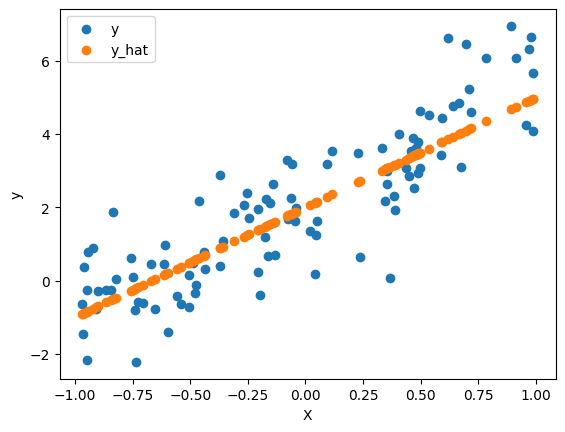

In [3]:
size = 100
X = torch.ones(size, 2)
X[:, 0].uniform_(-1., 1)

y_hat = 3 * X[:, 0] + 2
y = y_hat + torch.randn(size)

loss_animator = LossAnimator(X, y)

plt.scatter(loss_animator.X[:,0], loss_animator.y, label='y');
plt.scatter(loss_animator.X[:,0], y_hat, label='y_hat');
plt.xlabel('X')
plt.ylabel('y')
plt.legend()

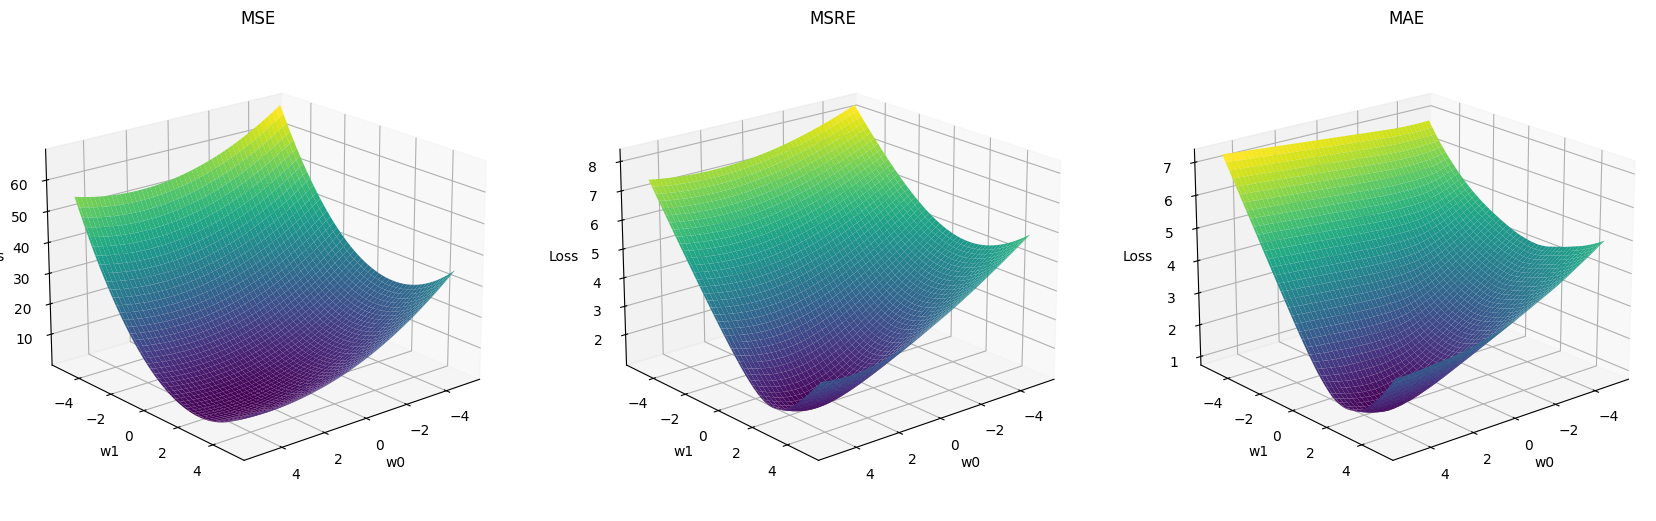

In [4]:
weights = grid_samples()
loss_animator.plot_loss_funcs(weights, [mse, msre, mae], ['MSE', 'MSRE', 'MAE'])

<i> 1.1 Реализуем методы SGD, NAG, Adagrad, RMSProp</i>:

In [5]:
class Optimizer:
    def __init__(self, params):
        self.params = list(params)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

    def pre_step(self):
        pass

    def step(self):
        pass

    def update_param(self, p):
        raise NotImplementedError()


In [6]:
def optimize_function(fn, optim, optim_args, start_point, num_iter = 50):
    weigths = nn.Parameter(torch.FloatTensor(start_point), requires_grad=True)

    optim = optim(params=[weigths], **optim_args)
    points = []
    losses = []
    for i in range(num_iter):
        if hasattr(optim, 'pre_step'):
            optim.pre_step()
        loss = fn(weigths)
        points.append(weigths.data.detach().clone())
        losses.append(loss.item())
        loss.backward()
        optim.step()
        optim.zero_grad()
    points = torch.stack(points, axis=0)
    losses = torch.FloatTensor(losses)
    return points, losses


In [7]:
def compare_optimizers(
    loss_animator,
    fn,
    optim_list,
    start_point,
    num_iter = 50,
    step_skip = 1
):
    data = {}
    loss_func = partial(loss_animator.loss_func, loss=fn)
    for name, optim, args in optim_list:
        points, losses = optimize_function(loss_func, optim, args, start_point, num_iter)
        data[name] = {
            'weights': points,
            'losses': losses,
        }

    return loss_animator.animate(num_iter, data, step_skip=step_skip)

### SGD
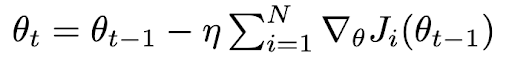

In [8]:
class SGD(Optimizer):
    def __init__(self, params, lr=1e-2):
        super().__init__(params)
        self.lr = lr

    def step(self):
        with torch.no_grad():
            for p in self.params:
                if p.grad is not None:
                    p -= self.lr * p.grad


### Nesterov accelerated gradient
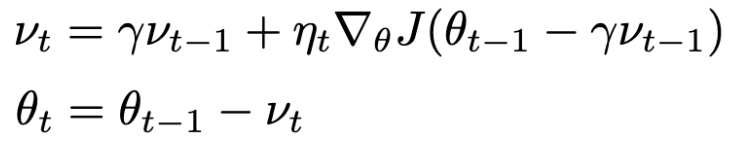

In [9]:
class NAG(Optimizer):
    def __init__(self, params, lr=1e-2, gamma=0.9):
        super().__init__(params)
        self.lr = lr
        self.gamma = gamma

        self.momentum = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    prev_momentum = self.momentum[i]
                    self.momentum = self.gamma * prev_momentum + self.lr * p.grad
                    p -= (1 + self.gamma) * self.momentum[i] - self.gamma * prev_momentum


### AdaGrad
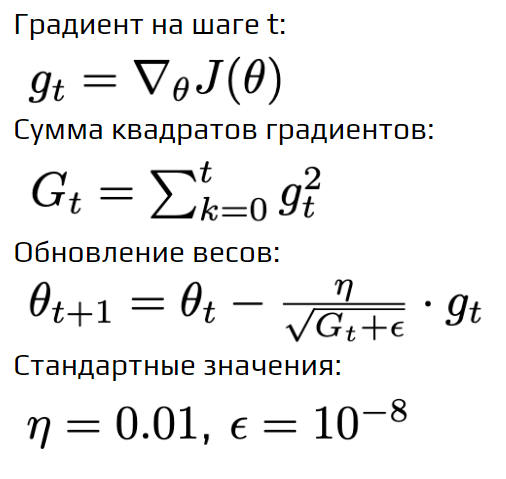

In [10]:
class AdaGrad(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2):
        super().__init__(params)

        self.eta = eta
        self.epsilon = epsilon

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] += p.grad ** 2
                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad

### RMSProp

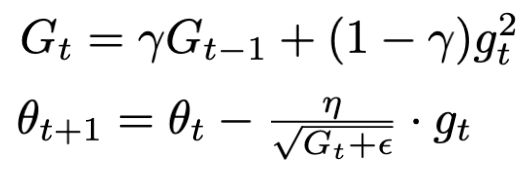

In [11]:
class RMSProp(Optimizer):
    def __init__(self, params, epsilon=1e-8, eta=1e-2, gamma=0.9):
        super().__init__(params)

        self.epsilon = epsilon
        self.eta = eta
        self.gamma = gamma

        self.G = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:

                    self.G[i] = self.gamma * self.G[i] + (1 - self.gamma) * (p.grad ** 2)

                    p -= self.eta / torch.sqrt(self.G[i] + self.epsilon) * p.grad



In [55]:
from functools import partial

points, losses = optimize_function(partial(loss_animator.loss_func, loss=mse), AdaDelta, {'eps': 1e-8}, start_point=[-4, -4], num_iter=100)

In [24]:
plt.rcParams['animation.ffmpeg_path'] = r'C:\ffmpeg\bin\ffmpeg.exe'

In [25]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['NAG', NAG, {'lr': 1e-1}],
        ['AdaGrad', AdaGrad, {'eta': 1}],
        ['RMSProp', RMSProp, {'eta': 1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

C:\Users\inact1ve\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


В качестве домашней работы вам необходимо будет реализовать и сравнить методы:
<b>Momentum, AdaDelta, Adam</b>.

Также вам будет предложено сравнить реализованные методы при обучении полносвязной и сверточной нейронных сетей на датасете MNIST.



In [26]:
class Momentum(Optimizer):
    def __init__(self, params, eta=1e-2, gamma=0.9):
        super().__init__(params)

        self.eta = eta
        self.gamma = gamma

        self.V = [torch.zeros(p.shape) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    self.V[i] = self.gamma * self.V[i] + self.eta * p.grad
                    p -= self.V[i]

In [50]:
class AdaDelta(Optimizer):
    def __init__(self, params, rho=0.99, eps=1e-1):
        super().__init__(params)

        self.rho = rho
        self.eps = eps

        self.E_delta_x = [torch.zeros_like(p) for p in self.params]
        self.E_delta_theta = [torch.zeros_like(p) for p in self.params]

    def step(self):
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    grad = p.grad
                    self.E_delta_x[i] = self.rho * self.E_delta_x[i] + (1 - self.rho) * grad ** 2
                    delta_x = torch.sqrt(self.E_delta_theta[i] + self.eps) / torch.sqrt(self.E_delta_x[i] + self.eps) * grad
                    p -= delta_x
                    self.E_delta_theta[i] = self.rho * self.E_delta_theta[i] + (1 - self.rho) * delta_x ** 2


In [51]:
class Adam(Optimizer):
    def __init__(self, params, eta=1e-3, beta1=0.9, beta2=0.999, epsilon=1e-8):
        super().__init__(params)

        self.eta = eta
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        self.t = 0
        self.m = [torch.zeros_like(p) for p in self.params]
        self.v = [torch.zeros_like(p) for p in self.params]

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.params):
                if p.grad is not None:
                    self.m[i] = self.beta1 * self.m[i] + (1 - self.beta1) * p.grad
                    self.v[i] = self.beta2 * self.v[i] + (1 - self.beta2) * (p.grad ** 2)
                    
                    m_hat = self.m[i] / (1 - self.beta1 ** self.t)
                    v_hat = self.v[i] / (1 - self.beta2 ** self.t)
                    
                    p -= self.eta * m_hat / (torch.sqrt(v_hat) + self.epsilon)

Сравним методы аналогично с семинаром, также оставим SGD

In [52]:
compare_optimizers(
    loss_animator,
    mse,
    [
        ['SGD', SGD, {'lr': 1e-1}],
        ['Momentum', Momentum, {'eta': 1e-1}],
        ['AdaDelta', AdaDelta, {}],
        ['Adam', Adam, {'eta': 1e-1}],
    ],
    start_point=[-4, -4],
    num_iter=100
)

В результате получаем, что все оптимизаторы сошлись, при этом каждый обладает своими особенностями:
1. Momentum сходится довольно шумно, вероятно это связано с инерцией при обновлении весов, что заставляет его прыгать сильнее
2. Adam сходится ровно, при этом довольно медленно в сравнении с остальными методами, возможно стоит подобрать параметры адекватнее
3. AdaDelta сходится быстрее всех, при этом (на мой взгляд) он более чувствителен к параметрам, потому что изменение eps на 2 порядка привело к сильному изменению поведения, чего не было замечено у остальных методов

Попробуем применить эти оптимизаторы на MNIST, используем код получения данных и разбивки на трейн и тест из семинара 2

In [93]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torchvision
from IPython.display import clear_output
import sys
%matplotlib inline

In [72]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Возьмем простую сеть и лосс - кросс-энтропию

In [113]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [114]:
network = NeuralNetwork()
loss_f = nn.CrossEntropyLoss()
optimizer = Adam(network.parameters())

Обучим сеть с помощью реализованных оптимизаторов и посмотрим как изменяется качество на трейне и валидации

In [126]:
def train():
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []
    for epoch in range(5):
        running_train_loss = 0.0
        running_test_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_test = 0
        total_test = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = network(inputs)
            loss = loss_f(outputs, labels)
            loss.backward()
            optimizer.step()
            running_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_loss = running_train_loss / len(train_loader)
        train_losses.append(train_loss)
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = network(images)
                loss = loss_f(outputs, labels)
                running_test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_loss = running_test_loss / len(test_loader)
        test_losses.append(test_loss)
        test_accuracy = 100 * correct_test / total_test
        test_accuracies.append(test_accuracy)
            
        print(f'Epoch {epoch+1}, Train Loss: {running_train_loss/len(train_loader)}, Test Loss: {running_test_loss/len(test_loader)}')

    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(range(1, 6), train_losses, label='Train')
    plt.plot(range(1, 6), test_losses, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, 6), train_accuracies, label='Train')
    plt.plot(range(1, 6), test_accuracies, label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracies')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Epoch 1, Train Loss: 0.016702354909085934, Test Loss: 0.11713082769282718
Epoch 2, Train Loss: 0.01618548070325864, Test Loss: 0.13453779612455896
Epoch 3, Train Loss: 0.01412798735288061, Test Loss: 0.12530324495537698
Epoch 4, Train Loss: 0.014935268448286878, Test Loss: 0.14477424113820062
Epoch 5, Train Loss: 0.014045929523656587, Test Loss: 0.1326653168431686


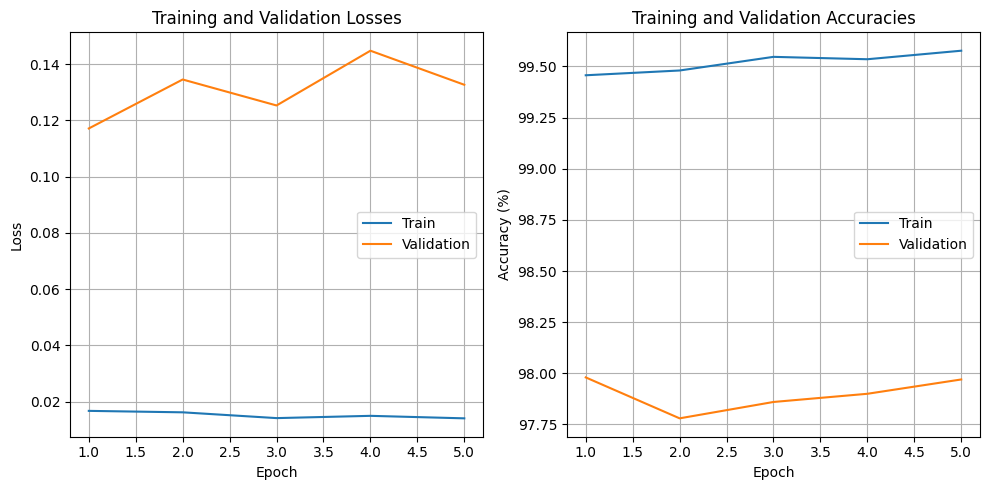

In [127]:
train()

Мы почти сразу попали в минимум, поэтому вероятно двигаться было особо некуда, значения точности выглядят хорошо

In [128]:
network = NeuralNetwork()
loss_f = nn.CrossEntropyLoss()
optimizer = Momentum(network.parameters())

Epoch 1, Train Loss: 0.2504422245673835, Test Loss: 0.11121219603869968
Epoch 2, Train Loss: 0.1016957383506, Test Loss: 0.09720159414634942
Epoch 3, Train Loss: 0.06923569961688482, Test Loss: 0.08340308223856605
Epoch 4, Train Loss: 0.051499390950022886, Test Loss: 0.09808884545882306
Epoch 5, Train Loss: 0.03934546709273321, Test Loss: 0.08051104873549031


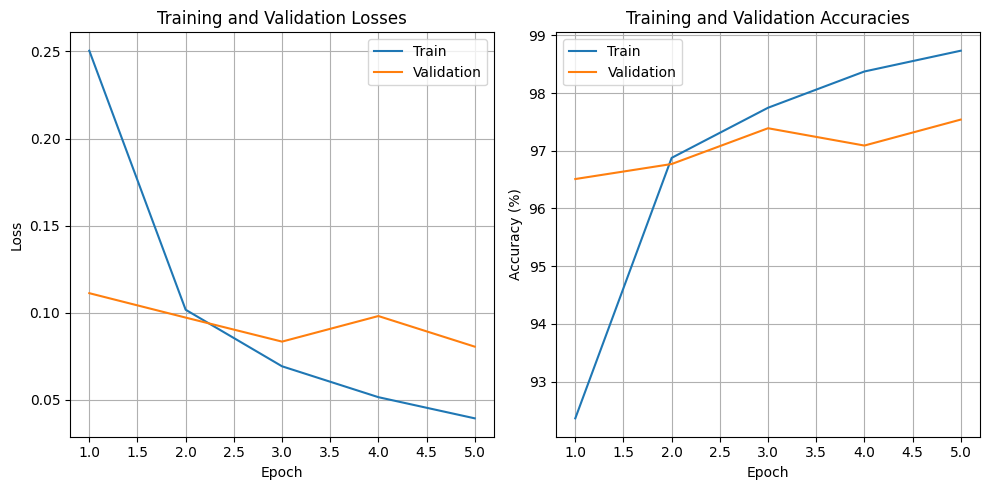

In [129]:
train()

Лосс на трейне стабильно падает, на валидации есть небольшие колебания, при этом значения точности также выглядят хорошо

In [138]:
network = NeuralNetwork()
loss_f = nn.CrossEntropyLoss()
optimizer = AdaDelta(network.parameters(), rho=0.9, eps=1e-8)

Epoch 1, Train Loss: 0.335061030520002, Test Loss: 0.19198033396011818
Epoch 2, Train Loss: 0.16649118027885754, Test Loss: 0.13770443361963683
Epoch 3, Train Loss: 0.12246140155767402, Test Loss: 0.11240083086821355
Epoch 4, Train Loss: 0.09756617298647761, Test Loss: 0.09948074980006634
Epoch 5, Train Loss: 0.08047217793595046, Test Loss: 0.09206341552707484


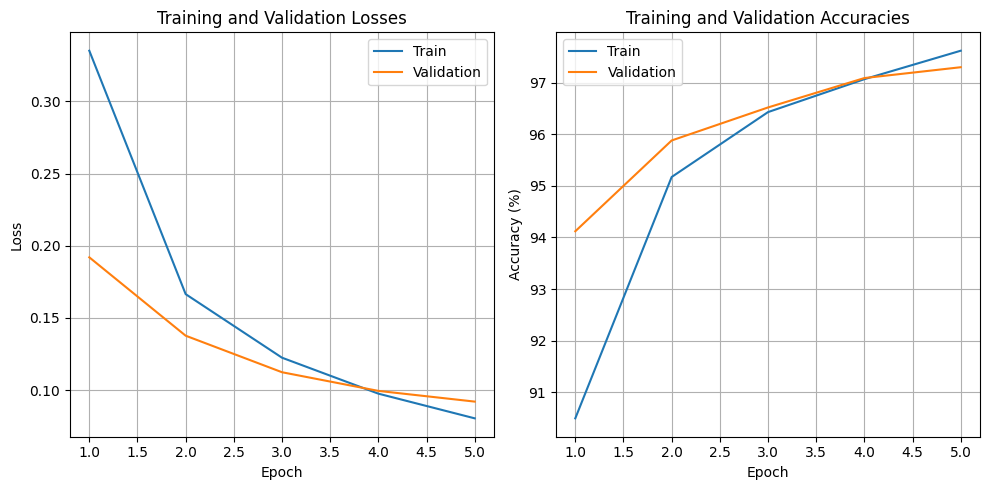

In [139]:
train()

Оказался самый карпризный оптимизатор, пришлось снова перебирать параметы, при этом лосс стабильно падает, точность растет на уровне других оптимизаторов